In [2]:
import numpy as np
np.random.seed(2016)

import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
from scipy import misc
import numpy
import plotly as pl2

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D,Conv2D
from keras.layers import Concatenate
from keras.utils import np_utils
from keras.models import load_model
from sklearn.metrics import log_loss
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger

from keras import backend as K
K.set_image_dim_ordering('th')

from matplotlib import pyplot as plt #for imshow
from matplotlib.collections import PatchCollection
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction import image #image patching
from sklearn.decomposition import PCA as sklearnPCA
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, gridplot
from bokeh.plotting import figure, show, output_file
output_notebook()

# import plotly.offline as py
# import plotly.graph_objs as go

# py.init_notebook_mode()

import plotly
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

import warnings #turn-off warnings
warnings.filterwarnings("ignore")

#------- Parameters -------------#
global nb_classes
global img_rows
global img_cols
global channel

nb_classes = 4
img_rows, img_cols = 32,32 # input image dimensions (be resized to this!)
channel = 3

Loading BokehJS ...

In [3]:
def get_im(path):
    # Load as grayscale
    img = misc.imread(path, mode='RGB')
    #img = cv2.imread(path, 0)
    # Reduce size
    resized = cv2.resize(img, (img_rows, img_cols))
    return resized

Loaded train images
Size Training Data 214776
Size Training Target (214776,)
Loaded val images
Size Val Data 46024
Size Val Target (46024,)
Loaded test images
Size Test Data 46024
Size Test Target (46024,)


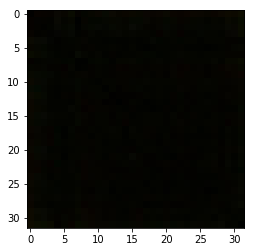

In [5]:
def load_data(path1):
    X = []
    path = os.path.join('.', path1, '*.jpg')  
    files = glob.glob(path)
    #sorted(list(map(int, files)))
    for fl in files:
        #print ("Current File Being Processed is: " + fl)
        img = get_im(fl)
        X.append(img)
    Y = np.full(len(X), int(path1[0]))
    return X, Y


#FOR TRAIN DATA
train_data = [] 
train_data, train_target = load_data('0_train_final')
train_data1, train_target1 = load_data('1_train_final')
train_data2, train_target2 = load_data('2_train_final')
train_data3, train_target3 = load_data('3_train_final')
print('Loaded train images')
train_data.extend(train_data1)
train_data.extend(train_data2)
train_data.extend(train_data3)
print('Size Training Data',len(train_data))
train_target = np.append(train_target, train_target1)
train_target = np.append(train_target, train_target2)
train_target = np.append(train_target, train_target3)
print('Size Training Target',train_target.shape)
train_data = np.array(train_data, dtype=np.uint8)

#FOR VAL DATA
val_data = []
val_data, val_target = load_data('0_val_final')
val_data1, val_target1 = load_data('1_val_final')
val_data2, val_target2 = load_data('2_val_final')
val_data3, val_target3 = load_data('3_val_final')
print('Loaded val images')
val_data.extend(val_data1)
val_data.extend(val_data2)
val_data.extend(val_data3)
print('Size Val Data',len(val_data))
val_target = np.append(val_target, val_target1)
val_target = np.append(val_target, val_target2)
val_target = np.append(val_target, val_target3)
print('Size Val Target',val_target.shape)
val_data = np.array(val_data, dtype=np.uint8)

#FOR TEST DATA
test_data = []
test_data, test_target = load_data('0_test_final')
test_data1, test_target1 = load_data('1_test_final')
test_data2, test_target2 = load_data('2_test_final')
test_data3, test_target3 = load_data('3_test_final')
print('Loaded test images')
test_data.extend(test_data1)
test_data.extend(test_data2)
test_data.extend(test_data3)
print('Size Test Data',len(test_data))
test_target = np.append(test_target, test_target1)
test_target = np.append(test_target, test_target2)
test_target = np.append(test_target, test_target3)
print('Size Test Target',test_target.shape)
test_data = np.array(test_data, dtype=np.uint8)

# imshow
plt.imshow(train_data[0])
plt.pause(1)


#patches = image.extract_patches_2d(train_data[0], (50, 50)) # dense griding patches
#print(patches.shape)



In [9]:
train_data = train_data.reshape(train_data.shape[0], channel, img_rows, img_cols)
train_target = np_utils.to_categorical(train_target, nb_classes)
train_data = train_data.astype('float32')
train_data /= 255
print('Train feat:', train_data.shape)
print('Train target:', train_target.shape)

val_data = val_data.reshape(val_data.shape[0], channel, img_rows, img_cols)
val_target = np_utils.to_categorical(val_target, nb_classes)
val_data = val_data.astype('float32')
val_data /= 255
print('Val feat:', val_data.shape)
print('Val target:', val_target.shape)

test_data = test_data.reshape(test_data.shape[0], channel, img_rows, img_cols)
test_target = np_utils.to_categorical(test_target, nb_classes)
test_data = test_data.astype('float32')
test_data /= 255
print('Test feat:', test_data.shape)
print('Test target:', test_target.shape)

X_train = train_data
Y_train = train_target
X_val = val_data
Y_val = val_target
X_test = test_data
Y_test = test_target

Train feat: (214776, 3, 32, 32)
Train target: (214776, 4)
Val feat: (46024, 3, 32, 32)
Val target: (46024, 4)
Test feat: (46024, 3, 32, 32)
Test target: (46024, 4)


Train on 214776 samples, validate on 46024 samples
Epoch 1/200
214776/214776 [==============================] - 338s 2ms/step - loss: 0.7246 - acc: 0.6706 - val_loss: 0.7116 - val_acc: 0.6736
Epoch 2/200
214776/214776 [==============================] - 338s 2ms/step - loss: 0.6927 - acc: 0.6912 - val_loss: 0.7454 - val_acc: 0.6368
Epoch 3/200
214776/214776 [==============================] - 340s 2ms/step - loss: 0.6828 - acc: 0.6981 - val_loss: 0.7396 - val_acc: 0.6459
Epoch 4/200
214776/214776 [==============================] - 337s 2ms/step - loss: 0.6773 - acc: 0.7006 - val_loss: 0.6462 - val_acc: 0.7172
Epoch 5/200
214776/214776 [==============================] - 330s 2ms/step - loss: 0.6714 - acc: 0.7047 - val_loss: 0.6977 - val_acc: 0.6882
Epoch 6/200
214776/214776 [==============================] - 312s 1ms/step - loss: 0.6673 - acc: 0.7065 - val_loss: 0.7543 - val_acc: 0.6452
Epoch 7/200
214776/214776 [==============================] - 311s 1ms/step - loss: 0.6644 - acc: 0.7094

214776/214776 [==============================] - 310s 1ms/step - loss: 0.6418 - acc: 0.7219 - val_loss: 0.6571 - val_acc: 0.7102
Epoch 59/200
214776/214776 [==============================] - 309s 1ms/step - loss: 0.6414 - acc: 0.7223 - val_loss: 0.6395 - val_acc: 0.7226
Epoch 60/200
214776/214776 [==============================] - 308s 1ms/step - loss: 0.6416 - acc: 0.7217 - val_loss: 0.6255 - val_acc: 0.7281
Epoch 61/200
214776/214776 [==============================] - 309s 1ms/step - loss: 0.6406 - acc: 0.7234 - val_loss: 0.6393 - val_acc: 0.7214
Epoch 62/200
214776/214776 [==============================] - 310s 1ms/step - loss: 0.6414 - acc: 0.7219 - val_loss: 0.6194 - val_acc: 0.7337
Epoch 63/200
214776/214776 [==============================] - 316s 1ms/step - loss: 0.6408 - acc: 0.7216 - val_loss: 0.6574 - val_acc: 0.7104
Epoch 64/200
214776/214776 [==============================] - 314s 1ms/step - loss: 0.6405 - acc: 0.7230 - val_loss: 0.6365 - val_acc: 0.7208
Epoch 65/200
214776

214776/214776 [==============================] - 308s 1ms/step - loss: 0.6359 - acc: 0.7248 - val_loss: 0.6528 - val_acc: 0.7054
Epoch 116/200
214776/214776 [==============================] - 311s 1ms/step - loss: 0.6361 - acc: 0.7242 - val_loss: 0.6627 - val_acc: 0.7007
Epoch 117/200
214776/214776 [==============================] - 308s 1ms/step - loss: 0.6367 - acc: 0.7241 - val_loss: 0.6385 - val_acc: 0.7275
Epoch 118/200
214776/214776 [==============================] - 308s 1ms/step - loss: 0.6371 - acc: 0.7246 - val_loss: 0.6288 - val_acc: 0.7285
Epoch 119/200
214776/214776 [==============================] - 308s 1ms/step - loss: 0.6371 - acc: 0.7242 - val_loss: 0.6567 - val_acc: 0.6959
Epoch 120/200
214776/214776 [==============================] - 311s 1ms/step - loss: 0.6364 - acc: 0.7251 - val_loss: 0.6377 - val_acc: 0.7266
Epoch 121/200
214776/214776 [==============================] - 310s 1ms/step - loss: 0.6361 - acc: 0.7241 - val_loss: 0.6618 - val_acc: 0.7080
Epoch 122/200

214776/214776 [==============================] - 308s 1ms/step - loss: 0.6351 - acc: 0.7251 - val_loss: 0.6569 - val_acc: 0.7079
Epoch 173/200
214776/214776 [==============================] - 309s 1ms/step - loss: 0.6342 - acc: 0.7261 - val_loss: 0.6500 - val_acc: 0.7165
Epoch 174/200
214776/214776 [==============================] - 311s 1ms/step - loss: 0.6356 - acc: 0.7252 - val_loss: 0.6609 - val_acc: 0.7111
Epoch 175/200
214776/214776 [==============================] - 309s 1ms/step - loss: 0.6357 - acc: 0.7249 - val_loss: 0.6369 - val_acc: 0.7220
Epoch 176/200
214776/214776 [==============================] - 311s 1ms/step - loss: 0.6352 - acc: 0.7261 - val_loss: 0.6365 - val_acc: 0.7267
Epoch 177/200
214776/214776 [==============================] - 309s 1ms/step - loss: 0.6351 - acc: 0.7252 - val_loss: 0.6358 - val_acc: 0.7237
Epoch 178/200
214776/214776 [==============================] - 308s 1ms/step - loss: 0.6344 - acc: 0.7257 - val_loss: 0.6379 - val_acc: 0.7182
Epoch 179/200

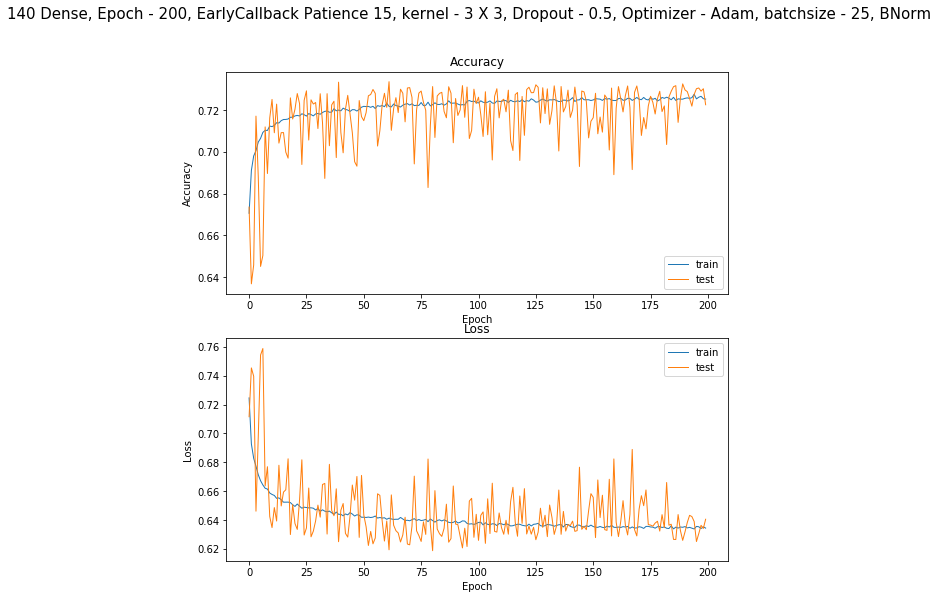

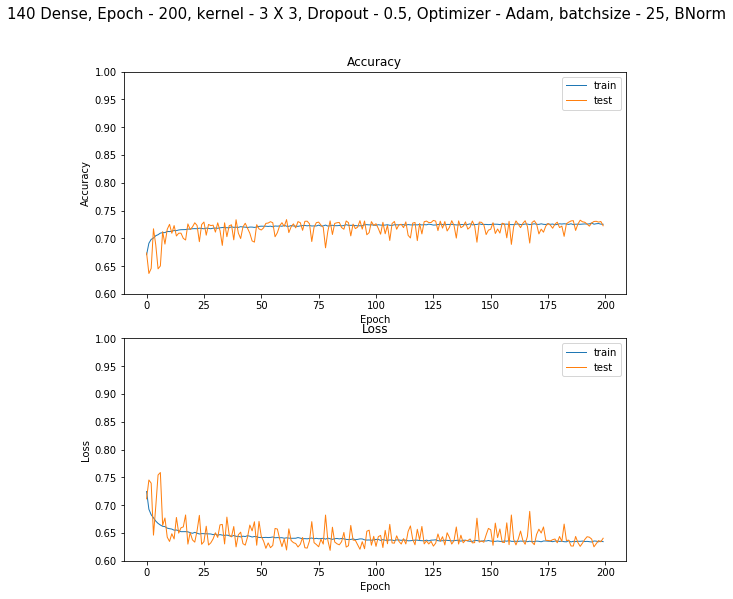

In [11]:
# 7. Define model architecture
model1 = Sequential()

model1.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(channel, img_rows, img_cols)))
model1.add(MaxPooling2D(pool_size=(4,4)))
model1.add(Convolution2D(32, 3, 3, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(BatchNormalization())
model1.add(Dense(140, activation='relu', kernel_initializer='uniform'))
model1.add(Dropout(0.5))
model1.add(Dense(nb_classes, activation='softmax',kernel_initializer='uniform'))
 
#opt = SGD(0.0025)
# 8. Compile model
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
#cb = [EarlyStopping(monitor = 'val_loss', patience = 20)]
h1 = model1.fit(X_train, Y_train, 
          batch_size=25, nb_epoch=200, verbose=1, validation_data = (X_val,Y_val))
 
# 10. Evaluate model on test data
score = model1.evaluate(X_test, Y_test, verbose=0)
print('Test accuarcy:', str(score))

# 11. Predicted labels
predictions = model1.predict([X_test])
#print('Prediction shape:', predictions.shape)
#print("Prediction: %s" % str(predictions[0:5]))
#print("Target: %s" % str(Y_test[0:5]))  # only show first 2 probas

real_labels = np.argmax(Y_test, axis=1)
p_labels = np.argmax(predictions, axis=1)

print('Recognition Rate:', 100*float(sum(real_labels == p_labels))/float(len(p_labels)))

plt.figure(1, figsize=(9,9))
plt.suptitle('140 Dense, Epoch - 200, EarlyCallback Patience 15, kernel - 3 X 3, Dropout - 0.5, Optimizer - Adam, batchsize - 25, BNorm', fontsize = 15)
plt.subplot(211)  
plt.plot(h1.history['acc'], linewidth = 1.0)  
plt.plot(h1.history['val_acc'], linewidth = 1.0)  
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h1.history['loss'], linewidth = 1.0)  
plt.plot(h1.history['val_loss'], linewidth = 1.0)  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 


plt.figure(2, figsize=(9,9))
plt.suptitle('140 Dense, Epoch - 200, kernel - 3 X 3, Dropout - 0.5, Optimizer - Adam, batchsize - 25, BNorm', fontsize = 15)
plt.subplot(211)  
plt.plot(h1.history['acc'], linewidth = 1.0)  
plt.plot(h1.history['val_acc'], linewidth = 1.0)  
plt.ylim(0.6,1.0)
plt.title('Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best') 

plt.subplot(212)  
plt.plot(h1.history['loss'], linewidth = 1.0)  
plt.plot(h1.history['val_loss'], linewidth = 1.0)  
plt.ylim(0.6,1.0)
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='best')  
plt.show() 

model1.save('timeseries_cnn_200epochs.h5')

In [13]:
rootdir = 'C:/Users/Kraljlab/Desktop/BigData_CNN_ImagesModel/well_test_final'
subdir_list = []
for subdir, dirs, files in os.walk(rootdir):
    subdir_list.append(subdir)
    #for file in files:
        #print(files[0])
        #print (os.path.join(subdir, file))
#print(subdir_list)
del subdir_list[0]

In [23]:
g = globals()
for i in range(0,480):
    if(i==198):
        continue
    f = glob.glob(os.path.join(subdir_list[i], '*.jpg'))
    name = '306k_list_{0}'.format(f[1][-9:-6]) # CHANGE THIS INDEX ACCORDINGLY
    name_array = '306k_arr_{0}'.format(f[1][-9:-6]) # CHANGE THIS INDEX ACCORDINGLY
    g[name] = []
    for fl in f:
        img = get_im(fl)
        g[name].append(img)
    g[name_array] = np.array(g[name], dtype=np.uint8)
    g[name_array] = g[name_array].reshape(g[name_array].shape[0], channel, img_rows, img_cols)
    #g[name_label]  = np_utils.to_categorical(g[name_label] , nb_classes)
    g[name_array] = g[name_array].astype('float32')
    g[name_array] /= 255

In [26]:
confidence_list = []
for i in range(1,481):
    if(i==199):
        continue
    g['306k_predictions_{num:03d}'.format(num=i)] = []
    g['306k_predictions_{num:03d}'.format(num=i)] = model1.predict([g['306k_arr_{num:03d}'.format(num=i)]])
    
    g['306k_plabels_{num:03d}'.format(num=i)] = np.argmax( g['306k_predictions_{num:03d}'.format(num=i)], axis=1)
    confidence_list.append(np.mean( g['306k_predictions_{num:03d}'.format(num=i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['306k_predictions_{num:03d}'.format(num=i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')

[6.9831955e-01 1.6555163e-01 1.3549487e-01 6.3390064e-04]


[7.0470101e-01 1.9117926e-01 1.0357976e-01 5.4000848e-04]


[0.6886499  0.13455382 0.17572877 0.00106748]


[0.35958105 0.12942521 0.50219464 0.00879907]


[7.1851271e-01 1.3217226e-01 1.4863428e-01 6.8066298e-04]


[0.50747573 0.37298417 0.11806102 0.00147919]


[0.6666792  0.13780391 0.19422048 0.0012964 ]


[0.5318859  0.09619127 0.36927915 0.00264369]


[0.7032623  0.10760429 0.1876843  0.00144939]


[6.5473026e-01 2.5997680e-01 8.4857449e-02 4.3548478e-04]


[0.6708784  0.09054559 0.23725727 0.0013187 ]


[0.53277045 0.06412473 0.40076306 0.00234153]


[0.32202974 0.0522645  0.6168286  0.00887721]


[0.69129395 0.1807649  0.12719019 0.00075074]


[6.1408061e-01 3.3804139e-01 4.7754906e-02 1.2312381e-04]


[0.6881596  0.19135028 0.11948649 0.00100368]


[0.45460045 0.06997166 0.47047657 0.00495124]


[7.3308283e-01 1.4099090e-01 1.2540352e-01 5.2271335e-04]


[0.48027948 0.44591686 0.07317541 0.00062843]


[7.2374219e-01 1

[6.6954750e-01 2.7451432e-01 5.5785879e-02 1.5235638e-04]


[0.24757844 0.04094627 0.7056795  0.00579592]


[0.28715223 0.04882945 0.6490536  0.01496467]


[5.2656639e-01 4.2673668e-01 4.6620987e-02 7.5982367e-05]


[6.3756061e-01 3.0994007e-01 5.2325640e-02 1.7370956e-04]


[7.176141e-01 2.068657e-01 7.528614e-02 2.341390e-04]


[0.22173627 0.01693057 0.75592583 0.00540729]


[7.2901553e-01 1.8882576e-01 8.1985176e-02 1.7364188e-04]


[0.30253357 0.6095161  0.07824685 0.0097036 ]


[7.1835810e-01 2.1009353e-01 7.1338095e-02 2.1013136e-04]


[0.3925649  0.03070208 0.57246596 0.00426696]


[7.2100633e-01 1.6309568e-01 1.1540463e-01 4.9331604e-04]


[5.5007929e-01 4.0627822e-01 4.3577630e-02 6.4837754e-05]


[7.2473109e-01 2.1358505e-01 6.1538450e-02 1.4559005e-04]


[6.9100201e-01 2.3027812e-01 7.8420579e-02 2.9945292e-04]


[4.8921743e-01 4.8007256e-01 3.0684935e-02 2.5000318e-05]


[6.4978683e-01 2.9782820e-01 5.2237324e-02 1.4777776e-04]


[0.39326245 0.06081071 0.5419618  0.00396513

[0.4465753  0.4695254  0.08282482 0.00107447]


[7.0085335e-01 2.1976213e-01 7.9044409e-02 3.4018321e-04]


[0.31729    0.07337578 0.60299265 0.00634168]


[0.6418867  0.2613927  0.09598397 0.00073668]


[5.0217777e-01 4.4623992e-01 5.1354975e-02 2.2733123e-04]


[6.9354141e-01 2.2090048e-01 8.5135572e-02 4.2252048e-04]


[6.7115498e-01 2.2617498e-01 1.0216130e-01 5.0888112e-04]


[5.5409408e-01 4.1285723e-01 3.3006281e-02 4.2484826e-05]


[6.8971926e-01 2.1198942e-01 9.7949244e-02 3.4215112e-04]


[0.16299641 0.00532241 0.82515293 0.00652811]


[6.7238933e-01 2.1276537e-01 1.1424093e-01 6.0437870e-04]


[6.3034564e-01 3.2320061e-01 4.6322137e-02 1.3162784e-04]


[7.5470680e-01 1.6967066e-01 7.5410694e-02 2.1170030e-04]


[0.09229464 0.00411987 0.8940437  0.00954172]


[7.0043117e-01 2.4224889e-01 5.7170223e-02 1.4966201e-04]


[5.9790909e-01 3.6346725e-01 3.8567435e-02 5.6248678e-05]


[6.8040299e-01 2.5332105e-01 6.6041283e-02 2.3467180e-04]


[0.10757648 0.013432   0.87000555 0.0089

[7.6211095e-01 1.5378833e-01 8.3844595e-02 2.5625457e-04]


[6.5321094e-01 3.0639571e-01 4.0334087e-02 5.9234491e-05]


[7.5907165e-01 1.7265700e-01 6.8135776e-02 1.3542471e-04]


[7.1176916e-01 2.2455624e-01 6.3531555e-02 1.4311091e-04]


[5.5766797e-01 4.1154793e-01 3.0765681e-02 1.8326135e-05]


[7.5362420e-01 1.6854106e-01 7.7550970e-02 2.8346584e-04]


[0.28117868 0.03808874 0.67584074 0.00489196]


[7.7067316e-01 1.4085998e-01 8.8208862e-02 2.5789099e-04]


[6.3137430e-01 3.3145744e-01 3.7114892e-02 5.3396783e-05]


[7.5655001e-01 1.6830233e-01 7.4980855e-02 1.6662940e-04]


[0.2970664  0.04863682 0.6489434  0.0053532 ]


[7.547437e-01 1.776799e-01 6.740728e-02 1.694104e-04]


[5.4288292e-01 4.2510304e-01 3.1933848e-02 8.0094207e-05]


[7.5501770e-01 1.7484570e-01 6.9952026e-02 1.8443275e-04]


[0.30754834 0.04324332 0.64424336 0.00496498]


[0.26150686 0.02582564 0.7069668  0.00570058]


[6.8108416e-01 2.5727195e-01 6.1455168e-02 1.8873291e-04]


[5.5928642e-01 3.8656047e-01 5.3

In [64]:
dmso = []
cccp = []
apramycin = []
#well 200 is 199 now. -1 for all subsequent wells after 199
for i in range(0,479):
    dmso.append(confidence_list[i][0])
    cccp.append(confidence_list[i][1])
    apramycin.append(confidence_list[i][2])

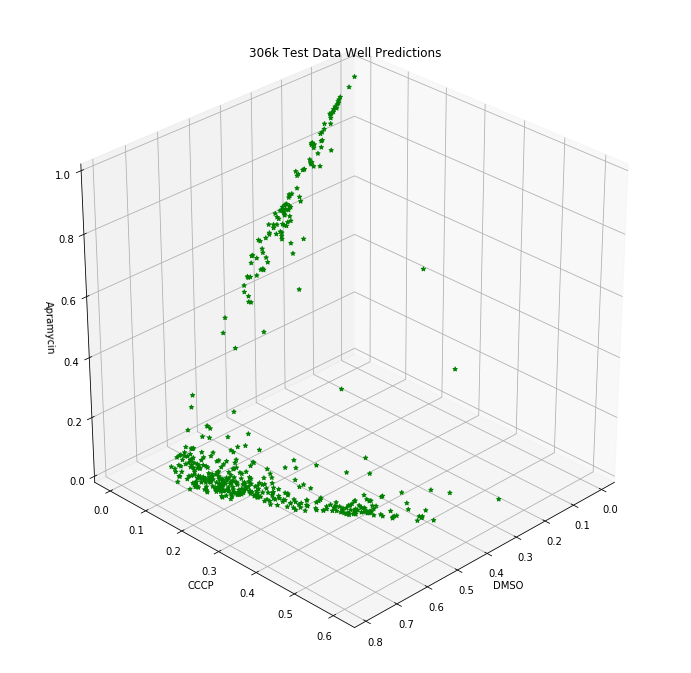

In [65]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

area = np.full(479,(20))
ax.scatter(dmso,cccp,apramycin,alpha=1,facecolor='g',marker="*",s=area)

ax.set_zlim3d(0,1)
ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')
#plt.legend()
ax.view_init(30,45)
plt.title("306k Test Data Well Predictions")
plt.draw()
#plt.savefig('13plate.png',dpi=1000)
plt.show()

In [49]:
# starting from 1 idx
idx_dmso = [1,3,5,7,9,11,14,16,18,20,22,24,25,27,29,31,33,35,38,40,42,44,46,48,49,51,53,55,57,59,62,64,66,68,70,72,73,75,77,79,81,83,86,88,90,92,94,96,97,99,101,103,105,107,110,112,114,116,118,120,121,123,125,127,129,131,134,136,138,140,142,144,145,147,149,153,155,158,160,162,164,166,168,169,171,173,175,177,179,182,184,186,188,190,192,193,195,197,200,202,205,207,209,211,213,215,216,218,220,222,224,226,229,231,233,235,237,239,240,242,244,246,248,250,253,255,257,259,261,263,264,266,268,270,272,274,277,279,281,283,285,287,288,290,292,294,296,298,301,303,305,307,309,311,312,314,316,318,320,322,325,327,329,331,333,335,336,338,340,342,344,346,349,351,353,355,357,359,360,362,364,366,368,370,373,375,377,379,381,383,384,386,388,390,392,394,397,399,401,403,405,407,408,410,412,414,416,418,421,423,425,427,429,431,432,434,436,438,440,442,445,447,449,451,453,455,456,458,460,462,464,466,469,471,473,475,477,479]
idx_cccp = [2,6,10,15,19,23,26,30,34,39,43,47,50,54,58,63,67,71,74,78,82,87,91,95,98,102,106,111,115,119,122,126,130,135,139,143,146,150,154,159,163,167,170,174,178,183,187,191,194,198,201,206,210,214,217,221,225,230,234,238,241,245,249,254,258,262,265,269,273,278,282,286,289,293,297,302,306,310,313,317,321,326,330,334,337,341,345,350,354,358,361,365,369,374,378,382,389,393,398,402,406,409,413,417,422,426,430,433,437,441,446,450,454,457,461,465,470,474,478]
idx_apra = [4,8,12,13,17,21,28,32,36,37,41,45,52,56,60,61,65,69,76,80,84,85,89,93,100,104,109,113,117,124,128,132,133,137,141,148,152,156,157,161,165,172,176,180,181,185,189,196,199,203,204,208,212,219,223,227,228,232,236,243,247,251,252,256,260,267,271,275,276,280,284,291,295,300,304,308,315,319,323,324,332,339,343,347,348,352,356,363,367,371,372,376,380,387,391,395,396,400,404,411,415,419,420,424,428,435,439,443,444,448,452,459,463,467,468,472,476]
idx_corr = [108,151,299,328,385]

In [69]:
#correct one
idx_dmso = [0,2,4,6,8,10,13,15,17,19,21,23,24,26,28,30,32,34,37,39,41,43,45,47,48,50,52,54,56,58,61,63,65,67,69,71,72,74,76,78,80,82,85,87,89,91,93,95,96,98,100,102,104,106,109,111,113,115,117,119,120,122,124,126,128,130,133,135,137,139,141,143,144,146,148,152,154,157,159,161,163,165,167,168,170,172,174,176,178,181,183,185,187,189,191,192,194,196,199,201,204,206,208,210,212,214,215,217,219,221,223,225,228,230,232,234,236,238,239,241,243,245,247,249,252,254,256,258,260,262,263,265,267,269,271,273,276,278,280,282,284,286,287,289,291,293,295,297,300,302,304,306,308,310,311,313,315,317,319,321,324,326,328,330,332,334,335,337,339,341,343,345,348,350,352,354,356,358,359,361,363,365,367,369,372,374,376,378,380,382,383,385,387,389,391,393,396,398,400,402,404,406,407,409,411,413,415,417,420,422,424,426,428,430,431,433,435,437,439,441,444,446,448,450,452,454,455,457,459,461,463,465,468,470,472,474,476,478]
idx_cccp = [1,5,9,14,18,22,25,29,33,38,42,46,49,53,57,62,66,70,73,77,81,86,90,94,97,101,105,110,114,118,121,125,129,134,138,142,145,149,153,158,162,166,169,173,177,182,186,190,193,197,200,205,209,213,216,220,224,229,233,237,240,244,248,253,257,261,264,268,272,277,281,285,288,292,296,301,305,309,312,316,320,325,329,333,336,340,344,349,353,357,360,364,368,373,377,381,388,392,397,401,405,408,412,416,421,425,429,432,436,440,445,449,453,456,460,464,469,473,477]
idx_apramycin = [3,7,11,12,16,20,27,31,35,36,40,44,51,55,59,60,64,68,75,79,83,84,88,92,99,103,108,112,116,123,127,131,132,136,140,147,151,155,156,160,164,171,175,179,180,184,188,195,198,202,203,207,211,218,222,226,227,231,235,242,246,250,251,255,259,266,270,274,275,279,283,290,294,299,303,307,314,318,322,323,331,338,342,346,347,351,355,362,366,370,371,375,379,386,390,394,395,399,403,410,414,418,419,423,427,434,438,442,443,447,451,458,462,466,467,471,475]
idx_corr = [107,150,298,327,384]

In [186]:
len(idx_dmso)

238

In [67]:
alldrug_pd = pd.DataFrame(data = confidence_list)
alldrug_pd = pd.DataFrame(data = alldrug_pd.drop(columns = 3))
dmso_pd = pd.DataFrame(data= dmso)
cccp_pd = pd.DataFrame(data = cccp)
apra_pd = pd.DataFrame(data = apramycin)

In [70]:
#Confidence for all DMSO, CCCP, Apramycin Wells
print('** FOR DMSO WELLS ** \nMean - DMSO: {0}, CCCP: {1}, Apramycin: {2}, \nStd - DMSO: {3}, CCCP: {4}, Apramycin: {5} '.format( \
                                                                np.mean(dmso_pd[0].iloc[idx_dmso].values),\
                                                                np.mean(cccp_pd[0].iloc[idx_dmso].values),\
                                                                np.mean(apra_pd[0].iloc[idx_dmso].values),\
                                                                np.std(dmso_pd[0].iloc[idx_dmso].values), \
                                                                np.std(cccp_pd[0].iloc[idx_dmso].values), \
                                                                np.std(apra_pd[0].iloc[idx_dmso].values)))

print('\n** FOR CCCP WELLS ** \nMean - DMSO: {0}, CCCP: {1}, Apramycin: {2}, \nStd - DMSO: {3}, CCCP: {4}, Apramycin: {5} '.format( \
                                                                np.mean(dmso_pd[0].iloc[idx_cccp].values),\
                                                                np.mean(cccp_pd[0].iloc[idx_cccp].values),\
                                                                np.mean(apra_pd[0].iloc[idx_cccp].values),\
                                                                np.std(dmso_pd[0].iloc[idx_cccp].values), \
                                                                np.std(cccp_pd[0].iloc[idx_cccp].values), \
                                                                np.std(apra_pd[0].iloc[idx_cccp].values)))

print('\n** FOR APRA WELLS ** \nMean - DMSO: {0}, CCCP: {1}, Apramycin: {2}, \nStd - DMSO: {3}, CCCP: {4}, Apramycin: {5} '.format( \
                                                                np.mean(dmso_pd[0].iloc[idx_apramycin].values),\
                                                                np.mean(cccp_pd[0].iloc[idx_apramycin].values),\
                                                                np.mean(apra_pd[0].iloc[idx_apramycin].values),\
                                                                np.std(dmso_pd[0].iloc[idx_apramycin].values), \
                                                                np.std(cccp_pd[0].iloc[idx_apramycin].values), \
                                                                np.std(apra_pd[0].iloc[idx_apramycin].values)))

** FOR DMSO WELLS ** 
Mean - DMSO: 0.6991190530923235, CCCP: 0.20699501444562143, Apramycin: 0.09339410310783305, 
Std - DMSO: 0.04683912796608349, CCCP: 0.055512401471291474, Apramycin: 0.03386039562612484 

** FOR CCCP WELLS ** 
Mean - DMSO: 0.5542978411462126, CCCP: 0.3955226489225355, Apramycin: 0.049859109780743344, 
Std - DMSO: 0.07183888806359065, CCCP: 0.07486616201856998, Apramycin: 0.020303023381895068 

** FOR APRA WELLS ** 
Mean - DMSO: 0.276476414858276, CCCP: 0.038726652530618966, Apramycin: 0.6780032304107634, 
Std - DMSO: 0.12987083564836646, CCCP: 0.03910118292202916, Apramycin: 0.1546627673926802 


In [ ]:
df_well_test.iloc[np.asarray(np.where(df_well_test.iloc[:,0]==i)).tolist()[0],:].iloc[:,3:453].values

In [132]:
np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,192)), np.where(np.less_equal(idx_dmso,288))))

array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142], dtype=int64)

In [192]:
alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,192)), np.where(np.less_equal(idx_cccp,287)))).tolist()]].values.shape

(24, 3)

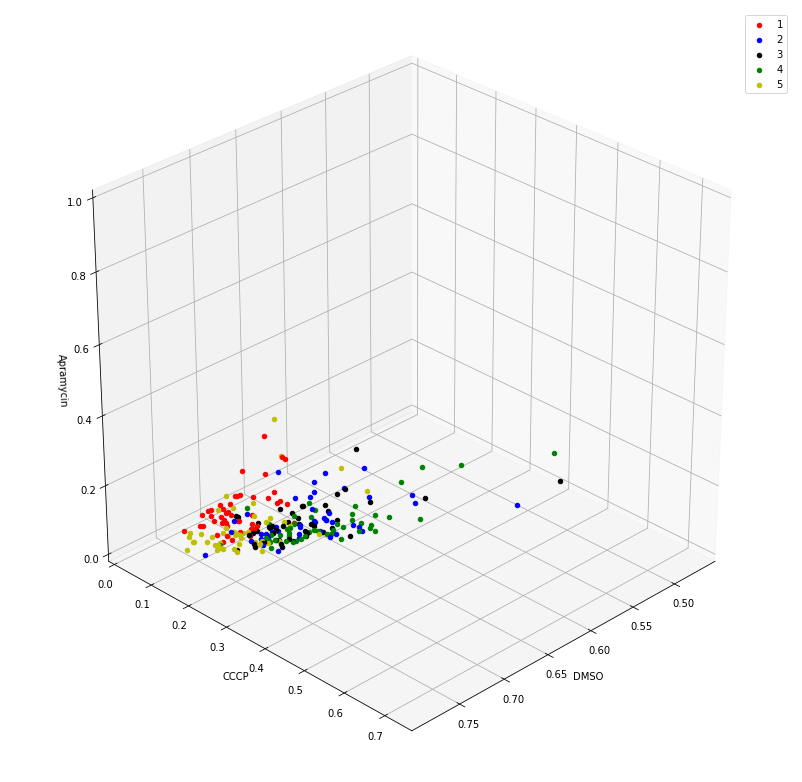

In [208]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

for i in range(0, len(alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.where(np.less_equal(idx_dmso,95))).tolist()[0]]].values.tolist())):
    for c, m, in [('r', 'o')]:
        ax.scatter(alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.where(np.less_equal(idx_dmso,95))).tolist()[0]]].values.tolist()[i][0], \
                   alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.where(np.less_equal(idx_dmso,95))).tolist()[0]]].values.tolist()[i][1], \
                   alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.where(np.less_equal(idx_dmso,95))).tolist()[0]]].values.tolist()[i][2], zdir=dmso,c=c,marker =m , label="1" if i == 0 else "")
        
for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,95)), np.where(np.less_equal(idx_dmso,192))))].values.tolist())):
    for c, m, in [('b', 'o')]:
        ax.scatter(alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,95)), np.where(np.less_equal(idx_dmso,192)))).tolist()]].values.tolist()[i][0], \
                   alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,95)), np.where(np.less_equal(idx_dmso,192)))).tolist()]].values.tolist()[i][1], \
                   alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,95)), np.where(np.less_equal(idx_dmso,192)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="2" if i == 0 else "")
        
for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,192)), np.where(np.less_equal(idx_dmso,288))))].values.tolist())):
    for c, m, in [('k', 'o')]:
        ax.scatter(alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,192)), np.where(np.less_equal(idx_dmso,288)))).tolist()]].values.tolist()[i][0], \
                   alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,192)), np.where(np.less_equal(idx_dmso,288)))).tolist()]].values.tolist()[i][1], \
                   alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,192)), np.where(np.less_equal(idx_dmso,288)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="3" if i == 0 else "")
for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,288)), np.where(np.less_equal(idx_dmso,384))))].values.tolist())):
    for c, m, in [('g', 'o')]:
        ax.scatter(alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,288)), np.where(np.less_equal(idx_dmso,384)))).tolist()]].values.tolist()[i][0], \
                   alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,288)), np.where(np.less_equal(idx_dmso,384)))).tolist()]].values.tolist()[i][1], \
                   alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,288)), np.where(np.less_equal(idx_dmso,384)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="4" if i == 0 else "")

for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,384)), np.where(np.less_equal(idx_dmso,480))))].values.tolist())):
    for c, m, in [('y', 'o')]:
        ax.scatter(alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,384)), np.where(np.less_equal(idx_dmso,480)))).tolist()]].values.tolist()[i][0], \
                   alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,384)), np.where(np.less_equal(idx_dmso,480)))).tolist()]].values.tolist()[i][1], \
                   alldrug_pd.iloc[[idx_dmso[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_dmso,384)), np.where(np.less_equal(idx_dmso,480)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="5" if i == 0 else "")

        
#FOR CCCP
# for i in range(0, len(alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.where(np.less_equal(idx_cccp,95))).tolist()[0]]].values.tolist())):
#     for c, m, in [('r', 'o')]:
#         ax.scatter(alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.where(np.less_equal(idx_cccp,95))).tolist()[0]]].values.tolist()[i][0], \
#                    alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.where(np.less_equal(idx_cccp,95))).tolist()[0]]].values.tolist()[i][1], \
#                    alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.where(np.less_equal(idx_cccp,95))).tolist()[0]]].values.tolist()[i][2], zdir=dmso,c=c,marker =m , label="1" if i == 0 else "")
        
# for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,95)), np.where(np.less_equal(idx_cccp,192))))].values.tolist())):
#     for c, m, in [('b', 'o')]:
#         ax.scatter(alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,95)), np.where(np.less_equal(idx_cccp,192)))).tolist()]].values.tolist()[i][0], \
#                    alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,95)), np.where(np.less_equal(idx_cccp,192)))).tolist()]].values.tolist()[i][1], \
#                    alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,95)), np.where(np.less_equal(idx_cccp,192)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="2" if i == 0 else "")
        
# for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,192)), np.where(np.less_equal(idx_cccp,288))))].values.tolist())):
#     for c, m, in [('k', 'o')]:
#         ax.scatter(alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,192)), np.where(np.less_equal(idx_cccp,288)))).tolist()]].values.tolist()[i][0], \
#                    alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,192)), np.where(np.less_equal(idx_cccp,288)))).tolist()]].values.tolist()[i][1], \
#                    alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,192)), np.where(np.less_equal(idx_cccp,288)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="3" if i == 0 else "")
# for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,288)), np.where(np.less_equal(idx_cccp,384))))].values.tolist())):
#     for c, m, in [('g', 'o')]:
#         ax.scatter(alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,288)), np.where(np.less_equal(idx_cccp,384)))).tolist()]].values.tolist()[i][0], \
#                    alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,288)), np.where(np.less_equal(idx_cccp,384)))).tolist()]].values.tolist()[i][1], \
#                    alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,288)), np.where(np.less_equal(idx_cccp,384)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="4" if i == 0 else "")

# for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,384)), np.where(np.less_equal(idx_cccp,480))))].values.tolist())):
#     for c, m, in [('y', 'o')]:
#         ax.scatter(alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,384)), np.where(np.less_equal(idx_cccp,480)))).tolist()]].values.tolist()[i][0], \
#                    alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,384)), np.where(np.less_equal(idx_cccp,480)))).tolist()]].values.tolist()[i][1], \
#                    alldrug_pd.iloc[[idx_cccp[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_cccp,384)), np.where(np.less_equal(idx_cccp,480)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="5" if i == 0 else "")
        

# #FOR APRA
# for i in range(0, len(alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.where(np.less_equal(idx_apramycin,95))).tolist()[0]]].values.tolist())):
#     for c, m, in [('r', 'o')]:
#         ax.scatter(alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.where(np.less_equal(idx_apramycin,95))).tolist()[0]]].values.tolist()[i][0], \
#                    alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.where(np.less_equal(idx_apramycin,95))).tolist()[0]]].values.tolist()[i][1], \
#                    alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.where(np.less_equal(idx_apramycin,95))).tolist()[0]]].values.tolist()[i][2], zdir=dmso,c=c,marker =m , label="1" if i == 0 else "")
        
# for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,95)), np.where(np.less_equal(idx_apramycin,192))))].values.tolist())):
#     for c, m, in [('b', 'o')]:
#         ax.scatter(alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,95)), np.where(np.less_equal(idx_apramycin,192)))).tolist()]].values.tolist()[i][0], \
#                    alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,95)), np.where(np.less_equal(idx_apramycin,192)))).tolist()]].values.tolist()[i][1], \
#                    alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,95)), np.where(np.less_equal(idx_apramycin,192)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="2" if i == 0 else "")
        
# for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,192)), np.where(np.less_equal(idx_apramycin,288))))].values.tolist())):
#     for c, m, in [('k', 'o')]:
#         ax.scatter(alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,192)), np.where(np.less_equal(idx_apramycin,288)))).tolist()]].values.tolist()[i][0], \
#                    alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,192)), np.where(np.less_equal(idx_apramycin,288)))).tolist()]].values.tolist()[i][1], \
#                    alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,192)), np.where(np.less_equal(idx_apramycin,288)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="3" if i == 0 else "")
# for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,288)), np.where(np.less_equal(idx_apramycin,384))))].values.tolist())):
#     for c, m, in [('g', 'o')]:
#         ax.scatter(alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,288)), np.where(np.less_equal(idx_apramycin,384)))).tolist()]].values.tolist()[i][0], \
#                    alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,288)), np.where(np.less_equal(idx_apramycin,384)))).tolist()]].values.tolist()[i][1], \
#                    alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,288)), np.where(np.less_equal(idx_apramycin,384)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="4" if i == 0 else "")

# for i in range(0, len(alldrug_pd.iloc[np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,384)), np.where(np.less_equal(idx_apramycin,480))))].values.tolist())):
#     for c, m, in [('y', 'o')]:
#         ax.scatter(alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,384)), np.where(np.less_equal(idx_apramycin,480)))).tolist()]].values.tolist()[i][0], \
#                    alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,384)), np.where(np.less_equal(idx_apramycin,480)))).tolist()]].values.tolist()[i][1], \
#                    alldrug_pd.iloc[[idx_apramycin[i] for i in np.asarray(np.intersect1d(np.where(np.greater(idx_apramycin,384)), np.where(np.less_equal(idx_apramycin,480)))).tolist()]].values.tolist()[i][2], zdir=dmso,c=c,marker =m, label="5" if i == 0 else "")
        

# ** FOR DMSO WELLS ** 
# Mean - DMSO: 0.6991190530923235, CCCP: 0.20699501444562143, Apramycin: 0.09339410310783305, 
# Std - DMSO: 0.04683912796608349, CCCP: 0.055512401471291474, Apramycin: 0.03386039562612484 

# ** FOR CCCP WELLS ** 
# Mean - DMSO: 0.5542978411462126, CCCP: 0.3955226489225355, Apramycin: 0.049859109780743344, 
# Std - DMSO: 0.07183888806359065, CCCP: 0.07486616201856998, Apramycin: 0.020303023381895068 

# ** FOR APRA WELLS ** 
# Mean - DMSO: 0.276476414858276, CCCP: 0.038726652530618966, Apramycin: 0.6780032304107634, 
# Std - DMSO: 0.12987083564836646, CCCP: 0.03910118292202916, Apramycin: 0.1546627673926802 

# #For DMSO
# circle = Circle((0.6991190530923235,0.20699501444562143),0.04683912796608349*3,alpha = .3, facecolor = 'r')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.09339410310783305,zdir="z")

# #For CCCP
# circle = Circle((0.5542978411462126,0.3955226489225355),0.07486616201856998*3,alpha = .5, facecolor = 'b')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.049859109780743344,zdir="z")

# #For Apramycin
# circle = Circle((0.276476414858276,0.6780032304107634),0.1546627673926802*3 ,alpha = .5, facecolor = 'k')
# ax.add_patch(circle)
# art3d.patch_2d_to_3d(circle,z=0.038726652530618966,zdir="y")

ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')

ax.set_zlim3d(0,1)
ax.set_ylim3d(0,0.75)

plt.legend()
ax.view_init(30,45)
plt.draw()
plt.show()

In [ ]:
#well 199 removed
#confusion between dmso and cccp
#try PCA
#plot for lstm cnn

In [85]:
df = pd.DataFrame(columns=['DMSOMean', 'CCCPMean', 'ApraMean', 'CorrMean', 'DMSOStd', 'CCCPStd', 'ApraStd','CorrStd', 'label'])
for j in range(1,481):
    dmso = []
    cccp = []
    apramycin = []
    corrupted = []
    if(j==199):
        continue
    for i in range(0,len(g['306k_predictions_{num:03d}'.format(num=j)])):
        dmso.append(g['306k_predictions_{num:03d}'.format(num=j)][i][0])
        cccp.append(g['306k_predictions_{num:03d}'.format(num=j)][i][1])
        apramycin.append(g['306k_predictions_{num:03d}'.format(num=j)][i][2])
        corrupted.append(g['306k_predictions_{num:03d}'.format(num=j)][i][3])
        
    df = df.append({'DMSOMean': np.mean(dmso), 'CCCPMean':np.mean(cccp), 'ApraMean': np.mean(apramycin), 'CorrMean': np.mean(corrupted), 'DMSOStd': np.std(dmso), 'CCCPStd': np.std(cccp), 'ApraStd': np.std(apramycin), 'CorrStd': np.std(corrupted)},ignore_index=True)


In [87]:
df.loc[idx_dmso,'label'] = df.iloc[idx_dmso].label.fillna(0,downcast = 'integer')
df.loc[idx_cccp,'label'] = df.iloc[idx_cccp].label.fillna(1,downcast = 'integer')
df.loc[idx_apramycin,'label'] = df.iloc[idx_apramycin].label.fillna(2,downcast = 'integer')
df.loc[idx_corr,'label'] = df.iloc[idx_corr].label.fillna(3,downcast = 'integer')

In [89]:
y = df.iloc[:,8].values.astype(int)

In [91]:
u,s,v = np.linalg.svd(df.iloc[:,0:8].values.T)

In [92]:
eig_pairs = [(np.abs(s[i]), u[:,i]) for i in range(len(u))]

In [93]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(8,1), 
                      eig_pairs[1][1].reshape(8,1)))
Y = df.iloc[:,0:8].values.dot(matrix_w)
p1 = figure(title="PC1 vs PC2", tools="pan,wheel_zoom,box_zoom,reset,save,box_select,hover")
p1.xaxis.axis_label = 'PC1'
p1.yaxis.axis_label = 'PC2'
for name,color in [("0","green"),("1","red"),("2","blue"),("3","orange")]:
        p1.circle(Y[y==int(name),0], Y[y==int(name),1]  , legend=name, color=color, size=7)
show(p1)

In [94]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(8,1), 
                      eig_pairs[2][1].reshape(8,1)))
Y = df.iloc[:,0:8].values.dot(matrix_w)
p1 = figure(title="PC1 vs PC3", tools="pan,wheel_zoom,box_zoom,reset,save,box_select,hover")
p1.xaxis.axis_label = 'PC1'
p1.yaxis.axis_label = 'PC3'
for name,color in [("0","green"),("1","red"),("2","blue"),("3","orange")]:
        p1.circle(Y[y==int(name),0], Y[y==int(name),1]  , legend=name, color=color, size=7)
show(p1)

In [95]:
matrix_w = np.hstack((eig_pairs[1][1].reshape(8,1), 
                      eig_pairs[2][1].reshape(8,1)))
Y = df.iloc[:,0:8].values.dot(matrix_w)

p1 = figure(title="PC2 vs PC3", tools="pan,wheel_zoom,box_zoom,reset,save,box_select,hover")
p1.xaxis.axis_label = 'PC2'
p1.yaxis.axis_label = 'PC3'
for name,color in [("0","green"),("1","red"),("2","blue"),("3","orange")]:
        p1.circle(Y[y==int(name),0], Y[y==int(name),1]  , legend=name, color=color, size=7)
show(p1)



In [96]:
tot = sum(s)
var_exp = [(i / tot)*100 for i in sorted(s, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['PC %s' %i for i in range(1,5)],
        y=var_exp,
        showlegend=False)

trace2 = Scatter(
        x=['PC %s' %i for i in range(1,5)], 
        y=cum_var_exp,
        name='cumulative explained variance')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Explained variance in percent'),
        title='variance by different principal components')

fig = Figure(data=data, layout=layout)
py.iplot(fig)

## 13 plate predictions

In [202]:
rootdir = 'C:/Users/Kraljlab/Desktop/plate13_test_final'
subdir_list = []
for subdir, dirs, files in os.walk(rootdir):
    subdir_list.append(subdir)
    #for file in files:
        #print(files[0])
        #print (os.path.join(subdir, file))
del subdir_list[0]
g = globals()
for i in range(0,96):
    f = glob.glob(os.path.join(subdir_list[i], '*.jpg'))
    name = 'thirteenplate_list_{0}'.format(f[1][-6:-4]) # CHANGE THIS INDEX ACCORDINGLY
    name_array = 'thirteenplate_arr_{0}'.format(f[1][-6:-4]) # CHANGE THIS INDEX ACCORDINGLY
    g[name] = []
    for fl in f:
        img = get_im(fl)
        g[name].append(img)
    g[name_array] = np.array(g[name], dtype=np.uint8)
    g[name_array] = g[name_array].reshape(g[name_array].shape[0], channel, img_rows, img_cols)
    #g[name_label]  = np_utils.to_categorical(g[name_label] , nb_classes)
    g[name_array] = g[name_array].astype('float32')
    g[name_array] /= 255
confidence_list = []
for i in range(1,97):
    g['th_plate_predictions_{0}'.format(i)] = []
    g['th_plate_predictions_{0}'.format(i)] = model1.predict([g['thirteenplate_arr_{num:02d}'.format(num=i)]])
    
    g['th_plate_plabels_{0}'.format(i)] = np.argmax( g['th_plate_predictions_{0}'.format(i)], axis=1)
    confidence_list.append(np.mean( g['th_plate_predictions_{0}'.format(i)],axis=0))
    #recognition.append(100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    
    print(np.mean( g['th_plate_predictions_{0}'.format(i)],axis=0))
    #print('Recognition Rate:', 100*float(sum(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1) == g['plabels_{0}'.format(i)]))/float(len(g['plabels_{0}'.format(i)])))
    #print('Actual Well Label:{0}, Well Number: {1}'.format(np.argmax(g['lab_{num:02d}'.format(num=i)],axis=1)[0],i ))
    print('\n')

[0.71505636 0.09791733 0.1859759  0.00105048]


[0.7192487  0.11959869 0.16037682 0.00077515]


[0.6472148  0.11443736 0.23477611 0.00357181]


[0.70084023 0.11724507 0.18074714 0.0011677 ]


[0.70356524 0.09209558 0.20331304 0.00102642]


[0.7409213  0.1312131  0.12711911 0.0007462 ]


[0.70900965 0.09223888 0.1977414  0.00101022]


[0.6674801  0.10816043 0.22241856 0.00194098]


[0.6878948  0.10025376 0.21064323 0.00120826]


[0.5250705  0.11292882 0.35365608 0.00834434]


[0.69801503 0.11361235 0.18724793 0.00112507]


[0.57122916 0.30762225 0.11695503 0.00419375]


[0.7031942  0.10266989 0.1930719  0.00106348]


[0.7210222  0.08314817 0.19484083 0.00098827]


[0.6914163  0.08404225 0.22330159 0.00123995]


[0.7189043  0.08766195 0.19253437 0.00089947]


[0.71881217 0.07754476 0.20255432 0.00108896]


[0.7198767  0.08843758 0.19072457 0.00096139]


[0.67836064 0.09933166 0.22132263 0.00098495]


[7.3642516e-01 9.8291509e-02 1.6455312e-01 7.3016202e-04]


[0.73275775 0.10841266 0.158

In [203]:
dmso = []
cccp = []
apramycin = []
for i in range(0,96):
    dmso.append(confidence_list[i][0])
    cccp.append(confidence_list[i][1])
    apramycin.append(confidence_list[i][2])

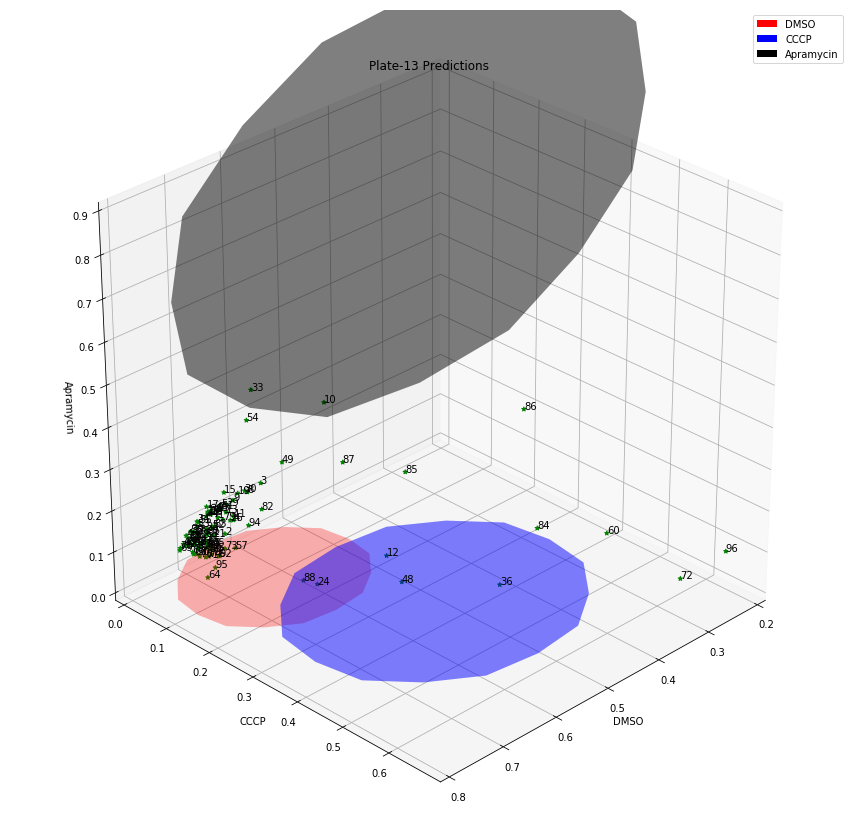

In [204]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

area = np.full(96,(20))
ax.scatter(dmso,cccp,apramycin,alpha=1,facecolor='g',marker="*",s=area)

#For DMSO
circle = Circle((0.6991190530923235,0.20699501444562143),0.04683912796608349*3,alpha = .3, facecolor = 'r')
ax.add_patch(circle)
art3d.patch_2d_to_3d(circle,z=0.09339410310783305,zdir="z")

#For CCCP
circle = Circle((0.5542978411462126,0.3955226489225355),0.07486616201856998*3,alpha = .5, facecolor = 'b')
ax.add_patch(circle)
art3d.patch_2d_to_3d(circle,z=0.049859109780743344,zdir="z")

#For Apramycin
circle = Circle((0.276476414858276,0.6780032304107634),0.1546627673926802*3 ,alpha = .5, facecolor = 'k')
ax.add_patch(circle)
art3d.patch_2d_to_3d(circle,z=0.038726652530618966,zdir="y")
well_number = np.arange(1,97)
classes = ['DMSO','CCCP','Apramycin']
class_colours = ['r','b','k']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc=1)
count1 = 0
for i,j,k in zip(dmso,cccp,apramycin):
    ax.text(i, j, k, str(well_number[count1]))
    count1+=1
    #ax.annotate(str(well_number[count1]),xy=(i,j,k))
    
ax.set_zlim3d(0,0.9)
ax.set_xlabel('DMSO')
ax.set_ylabel('CCCP')
ax.set_zlabel('Apramycin')
#plt.legend()
ax.view_init(30,45)
plt.title("Plate-13 Predictions")
plt.draw()
#plt.savefig('13plate.png',dpi=1000)
plt.show()